# XGBoost for early sepsis detection

----

We use **XGBoost** to build a collection of boosted trees, and use continuous data  from the Beth Israel Deaconess Medical Center and Emory University Hospital (collected from 2001 and 20012) made public through the **[PhysioNet Challenge 2019](https://physionet.org/content/challenge-2019/1.0.0/)**.

The data obtained is a 40.336 patient strong dataset.
We use the six most common ED vital signs (Heart rate, O2Sat, Temperature, Systolic BP, MAP, and Respiration rate) as features to predict sepsis.





In [3]:
import pandas as pd 
import numpy as np 
import xgboost as xgb 
from sklearn.model_selection import train_test_split # split  data into training and testing sets
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer # for scoring during cross validation
from sklearn.model_selection import GridSearchCV # cross validation
from sklearn.metrics import confusion_matrix # creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix

In [4]:
from google.colab import files
uploaded = files.upload()

Saving SepsisDataSet.csv to SepsisDataSet (1).csv


In [5]:
import io
df = pd.read_csv(io.BytesIO(uploaded['SepsisDataSet.csv']))
# Dataset is now stored in a Pandas Dataframe

In [7]:
df.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Patient_id,time
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.08,1,NaN,NaN,-0.01,1,0,0,0
1,85.0,100.0,NaN,121.0,79.67,NaN,16.0,NaN,NaN,NaN,0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.08,1,NaN,NaN,-0.01,2,0,0,1
2,72.0,100.0,NaN,110.0,72.67,NaN,16.0,NaN,NaN,24.0,NaN,NaN,NaN,NaN,NaN,16.0,NaN,8.9,105.0,1.2,NaN,259.0,NaN,1.5,2.8,4.2,NaN,NaN,36.8,NaN,NaN,10.5,NaN,237.0,60.08,1,NaN,NaN,-0.01,3,0,0,2
3,74.0,100.0,NaN,109.0,75.00,NaN,16.0,NaN,NaN,NaN,0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.08,1,NaN,NaN,-0.01,4,0,0,3
4,75.0,100.0,37.39,104.0,70.00,NaN,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.08,1,NaN,NaN,-0.01,5,0,0,4


Defining features that will be droped.


In [8]:
lab=['BaseExcess','HCO3','FiO2','pH','PaCO2','SaO2','AST','BUN','Alkalinephos','Calcium','Chloride','Creatinine','Bilirubin_direct','Glucose','Lactate',
      'Magnesium','Phosphate','Potassium','Bilirubin_total','TroponinI','Hct','Hgb','PTT','WBC','Fibrinogen','Platelets']

vitals = ['DBP','EtCO2']

demo = ['Age','Gender','Unit1','Unit2','HospAdmTime','ICULOS', 'Patient_id', 'time']

label = ['SepsisLabel']

First step for bulding a datapipline:

In [9]:
def drop_vitals(df):
    df.drop(vitals, axis = 1, inplace = True)
   
    
def drop_lab(df):
    df.drop(lab, axis = 1, inplace = True)

def drop_demo(df):
    df.drop(demo, axis = 1, inplace = True)

In [10]:
def carry_fwd_imp(df):
    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)

def drop_features(df):
    drop_vitals(df)
    drop_lab(df)
    drop_demo(df)
    

def drop_ado(df):
    df.drop(df[df.Age <= 15].index, inplace=True)

In [11]:
drop_ado(df)
drop_features(df)
carry_fwd_imp(df)

In [12]:
df.head()

,HR,O2Sat,Temp,SBP,MAP,Resp,SepsisLabel
0,85.0,100.0,37.39,121.0,79.67,16.0,0
1,85.0,100.0,37.39,121.0,79.67,16.0,0
2,72.0,100.0,37.39,110.0,72.67,16.0,0
3,74.0,100.0,37.39,109.0,75.00,16.0,0
4,75.0,100.0,37.39,104.0,70.00,16.0,0


# Build A Preliminary XGBoost Model


 we simply split the data into **training** and **testing** data sets and build the model. However, first, let's observe that this data is imbalanced by dividing the number of people who left the company, where `y = 1`, by the total number of people in the dataset. 


In [14]:
y = df['SepsisLabel']
df.drop(['SepsisLabel'], axis = 1, inplace = True)

In [15]:
sum(y)/len(y)

0.01798600086592582

So we see that only **1,8%** of the people in the dataset left the company. Because of this, when we split the data into training and testing, we will split using stratification in order to maintain the same percentage of people who left the company in both the **training** set and the **testing** set.

In [16]:
X_train, X_test, y_train, y_test = train_test_split(df, y, random_state=42, stratify=y)

Now let's verify that using `stratify` worked as expected...

In [17]:
sum(y_train)/len(y_train)

0.01798600086592582

In [ ]:
sum(y_test)/len(y_test)

`stratify` worked as expected and both `y_train` and `y_test` have the same percentage of people that left the company. Now let's build the preliminary model.

Instead of determining the optimal number of trees with cross validation, we will use **early stopping** to stop building trees when they no longer improve the situation.

In [19]:
clf_xgb = xgb.XGBClassifier(objective='binary:logistic', 
                            eval_metric="logloss", ## this avoids a warning...
                            missing=None, seed=42, 
                            use_label_encoder=False)


clf_xgb.fit(X_train, 
            y_train,
            verbose=True,
            ## the next three arguments set up early stopping.
            early_stopping_rounds=10,
            eval_metric='aucpr',
            eval_set=[(X_test, y_test)])


[0]	validation_0-aucpr:0.038469
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.039098
[2]	validation_0-aucpr:0.039337
[3]	validation_0-aucpr:0.039835
[4]	validation_0-aucpr:0.040509
[5]	validation_0-aucpr:0.040395
[6]	validation_0-aucpr:0.040436
[7]	validation_0-aucpr:0.040386
[8]	validation_0-aucpr:0.040404
[9]	validation_0-aucpr:0.040393
[10]	validation_0-aucpr:0.040398
[11]	validation_0-aucpr:0.040394
[12]	validation_0-aucpr:0.040388
[13]	validation_0-aucpr:0.040529
[14]	validation_0-aucpr:0.040508
[15]	validation_0-aucpr:0.040747
[16]	validation_0-aucpr:0.040734
[17]	validation_0-aucpr:0.040867
[18]	validation_0-aucpr:0.040958
[19]	validation_0-aucpr:0.041084
[20]	validation_0-aucpr:0.041244
[21]	validation_0-aucpr:0.041348
[22]	validation_0-aucpr:0.041485
[23]	validation_0-aucpr:0.041863
[24]	validation_0-aucpr:0.041859
[25]	validation_0-aucpr:0.042028
[26]	validation_0-aucpr:0.042038
[27]	validation_0-aucpr:0.042207
[28]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              silent=None, subsample=1, use_label_encoder=False, verbosity=1)

We see how it performs on the **Testing Dataset** by running the **Testing Dataset** down the model and drawing a **Confusion Matrix**.

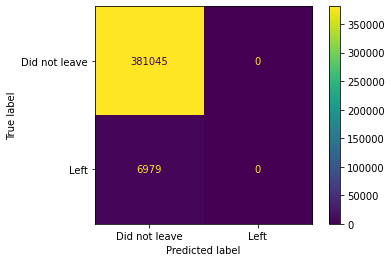

In [20]:
plot_confusion_matrix(clf_xgb, 
                      X_test, 
                      y_test,
                      values_format='d',
                      display_labels=["Did not leave", "Left"])

By labeling everything non-sepsis the model get **98%** accurecy...

# Optimize Parameters using Cross Validation and GridSearch()

**XGBoost** has a lot of *hyperparameters*, parameters that we have to manually configure and are not determined by **XGBoost** itself, including `max_depth`, the maximum tree depth, `learning_rate`, the learning rate, or "eta", `gamma`, the parameter that encourages pruning, and `reg_lambda`, the regularization parameter lambda. So let's try to find the optimal values for these hyperparameters in hopes that we can improve the accuracy with the **Testing Dataset**.

**NOTE:** Since we have many hyperparameters to optimize, we will use `GridSearchCV()`. We specify a bunch of potential values for the hyperparameters and `GridSearchCV()` tests all possible combinations of the parameters for us.

In [32]:
 ## NOTE: When data are imbalanced, the XGBoost manual says...
 ## If you care only about the overall performance metric (AUC) of your prediction
 ##     * Balance the positive and negative weights via scale_pos_weight
 ##     * Use AUC for evaluation
 ## ALSO NOTE: We ran GridSearchCV sequentially on subsets of parameter options, rather than all at once
 ## in order to optimize parameters in a short period of time.

 # ROUND 1
 #param_grid = {
 #    'max_depth': [5,6,7]
 #    'learning_rate': [0.1,0.5,1],
 #   ' gamma': [0, 0.25,0.75],
 #    'reg_lambda': [10,20,100],
 #    'scale_pos_weight': [55,60,65] # NOTE: XGBoost recommends sum(negative instances) / sum(positive instances)
 # }
 

# # Output: max_depth: 7, learning_rate: 0.1, gamma: 0, reg_lambda: 100, scale_pos_weight: 60
# # Because max_depth and reg_lambda were at the ends of their range, we will continue to explore those...

 ## ROUND 2
 param_grid = {
     'max_depth': [7,8,9],
     'learning_rate': [0.1],
     'gamma': [0],
     'reg_lambda': [100, 150, 200],
      'scale_pos_weight': [60]
  }
## Output: max_depth: 8, learning_rate: 0.1, reg_lambda: 100.

# NOTE: To speed up cross validiation, and to further prevent overfitting.
# We are only using a random subset of the data (90%) and are only
# using a random subset of the features (columns) (50%) per tree.
 optimal_params = GridSearchCV(
     estimator=xgb.XGBClassifier(objective='binary:logistic', 
                                 eval_metric="logloss", ## this avoids a warning...
                                 seed=42,
                                 subsample=0.9,
                                 colsample_bytree=0.5,
                                 use_label_encoder=False),
     param_grid=param_grid,
     scoring='roc_auc', 
     verbose=0, # If you want to see what Grid Search is doing, set verbose=2
     n_jobs = 10,
     cv = 3
 )

 optimal_params.fit(X_train, 
                    y_train, 
                    early_stopping_rounds=10,                
                    eval_metric='auc',
                    eval_set=[(X_test, y_test)],
                    verbose=False)
 print(optimal_params.best_params_)

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{' gamma': 0, 'learning_rate': 0.1, 'max_depth': 8, 'reg_lambda': 100, 'scale_pos_weight': 60}


So, after testing all possible combinations of the potential parameter values with **Cross Validation**, we see that we should set `gamma=0`, `learn_rate=0.1`, `max_depth=8`,  `scale_pos_weight=60`, and `reg_lambda=10`.

----

# Building, Evaluating, Drawing, and Interpreting the Optimized XGBoost Model

Now that we have the ideal parameter values, we can build the final **XGBoost** model:

In [28]:
clf_xgb = xgb.XGBClassifier(seed=42,
                        objective='binary:logistic',
                        eval_metric="logloss", ## this avoids warning...
                        gamma=0,
                        learning_rate=0.1,
                        max_depth=8,
                        reg_lambda=100,
                        scale_pos_weight=60,
                        subsample=0.9,
                        colsample_bytree=0.5,
                        use_label_encoder=False)
clf_xgb.fit(X_train, 
            y_train, 
            verbose=True, 
            early_stopping_rounds=10,
            eval_metric='auc',
            eval_set=[(X_test, y_test)])

[0]	validation_0-auc:0.63277
Will train until validation_0-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.635263
[2]	validation_0-auc:0.645493
[3]	validation_0-auc:0.650582
[4]	validation_0-auc:0.651461
[5]	validation_0-auc:0.652507
[6]	validation_0-auc:0.652644
[7]	validation_0-auc:0.652917
[8]	validation_0-auc:0.652936
[9]	validation_0-auc:0.670466
[10]	validation_0-auc:0.670955
[11]	validation_0-auc:0.68233
[12]	validation_0-auc:0.689377
[13]	validation_0-auc:0.694013
[14]	validation_0-auc:0.693645
[15]	validation_0-auc:0.693736
[16]	validation_0-auc:0.69349
[17]	validation_0-auc:0.696655
[18]	validation_0-auc:0.696235
[19]	validation_0-auc:0.696003
[20]	validation_0-auc:0.695751
[21]	validation_0-auc:0.696448
[22]	validation_0-auc:0.698386
[23]	validation_0-auc:0.698299
[24]	validation_0-auc:0.698591
[25]	validation_0-auc:0.700905
[26]	validation_0-auc:0.701131
[27]	validation_0-auc:0.70163
[28]	validation_0-auc:0.701929
[29]	validation_0-auc:0.703497
[30]	validation_0-au

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='logloss',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=100, scale_pos_weight=60, seed=42,
              silent=None, subsample=0.9, use_label_encoder=False, verbosity=1)

Now let's draw another confusion matrix to see if the optimized **XGBoost** model does better.

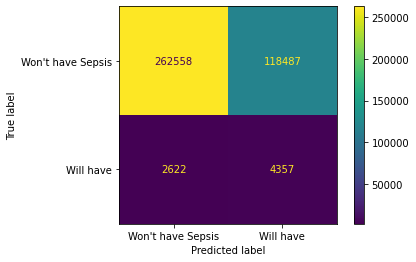

In [33]:
plot_confusion_matrix(clf_xgb, 
                      X_test, 
                      y_test,
                      values_format='d',
                      display_labels=["Won't have Sepsis", "Will have"])

We see that the optimized **XGBoost** model is better at identifying sepsis. Of the patient that developted sepsis, about **2/3**, were correctly identified. Before optimization, we correctly identified **0 (0%)**. However, this improvement was at the expense of not being able to correctly classify as many  non-septic patients. Before optimization, we correctly identified **all** non-septic patients. Now we only correctly classify about **2/3**. That said, this trade off is better since it is more sensible for sepsis patient. 

# Save Model as Pickle Object

We will save the model so we can inegrat it into the sepsis detection web app.

In [ ]:
import pickle

In [ ]:
pickle.dump(clf_xgb, open('xgb_clf_model.pkl', 'wb'))

# Drawing XGBoost Tree

The last thing we are going to do is draw the first **XGBoost Tree** and discuss how to interpret it, and save it to pdf

weight:  {'HR': 25, 'Resp': 19, 'O2Sat': 17}
gain:  {'HR': 2722.8444263319993, 'Resp': 2403.9058481052634, 'O2Sat': 665.0437755764705}
cover:  {'HR': 49814.29, 'Resp': 66938.6447368421, 'O2Sat': 42674.92647058824}
total_gain:  {'HR': 68071.11065829998, 'Resp': 45674.211114000005, 'O2Sat': 11305.744184799998}
total_cover:  {'HR': 1245357.25, 'Resp': 1271834.25, 'O2Sat': 725473.75}


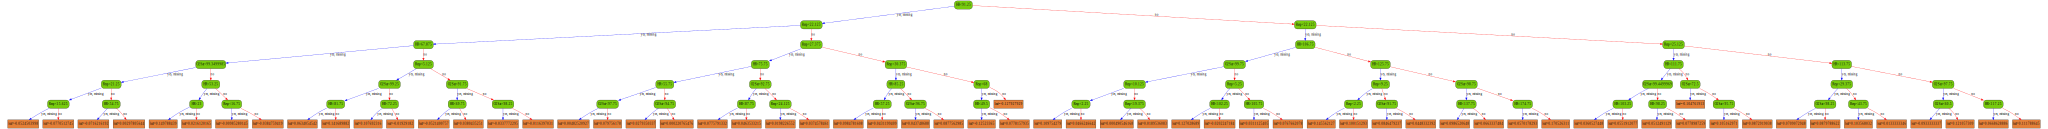

In [34]:
## If we want to get information, like gain and cover etc, at each node in the first tree, 
## we just build the first tree, otherwise we'll get the average over all of the trees.
clf_xgb = xgb.XGBClassifier(seed=42,
                        eval_metric="logloss", ## this avoids another warning...
                        objective='binary:logistic',
                        gamma=0,
                        learning_rate=0.1,
                        max_depth=6,
                        reg_lambda=10,
                        scale_pos_weight=60,
                        subsample=0.9,
                        colsample_bytree=0.5,
                        n_estimators=1, ## We set this to 1 so we can get gain, cover etc.)
                        use_label_encoder=False) 

clf_xgb.fit(X_train, y_train)

## now print out the weight, gain, cover etc. for the tree
## weight = number of times a feature is used in a branch or root across all trees
## gain = the average gain across all splits that the feature is used in
## cover = the average coverage across all splits a feature is used in
## total_gain = the total gain across all splits the feature is used in
## total_cover = the total coverage across all splits the feature is used in
## NOTE: Since we only built one tree, gain = total_gain and cover=total_cover
bst = clf_xgb.get_booster()
for importance_type in ('weight', 'gain', 'cover', 'total_gain', 'total_cover'):
    print('%s: ' % importance_type, bst.get_score(importance_type=importance_type))

node_params = {'shape': 'box', ## make the nodes fancy
               'style': 'filled, rounded',
               'fillcolor': '#78cbe'} 
leaf_params = {'shape': 'box',
               'style': 'filled',
               'fillcolor': '#e48038'}
## NOTE: num_trees is NOT the number of trees to plot, but the specific tree you want to plot
## The default value is 0, but I'm setting it just to show it in action since it is
## counter-intuitive.
# xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10") 

xgb.to_graphviz(clf_xgb, num_trees=0, 
                condition_node_params=node_params,
                leaf_node_params=leaf_params) 
## if you want to save the figure...
# graph_data = xgb.to_graphviz(clf_xgb, num_trees=0, size="10,10", 
#                 condition_node_params=node_params,
#                 leaf_node_params=leaf_params) 
# graph_data.view(filename='xgboost_tree_customer_churn') ## save as PDF